In [61]:
# Load packages
import numpy as np
import gymnasium as gym
# import torch
import random
import matplotlib.pyplot as plt
from tqdm import trange
from typing import List
from itertools import combinations, product



In [62]:
class Fourier_basis:

    def __init__(self, n_states, max_non_zero, p, type_coeffs, defined_coeffs):
        self.n_states = n_states #input size
        self.p = p
        self.max_non_zero = max_non_zero
        self.coeffs = self.define_coeffs(type_coeffs, defined_coeffs) 


    def define_coeffs(self, type_coeffs, defined_coeffs):
        
        if type_coeffs == "predefined":
            coeffs = defined_coeffs
        
        else:
            coeffs = np.array(np.zeros(self.n_states)) 

            for i in range(1, self.max_non_zero + 1):
                for indices in combinations(range(self.n_states), i):
                    for c in product(range(1, self.p + 1), repeat=i):
                        coef = np.zeros(self.n_states)
                        coef[list(indices)] = list(c)
                        coeffs = np.vstack((coeffs, coef))
        
        return coeffs

    def get_phi(self, state): ## to_basis
        return np.cos(np.pi*np.dot(self.coeffs, state))
    
    def scale_learning_rate(self, lr):
        norm = np.linalg.norm(self.coeffs, axis=1)
        norm[norm == 0.] = 1.  # When the norm is zero do not scale
        return lr / norm
    
    def get_num_basis(self):
        """Return the number of basis functions."""
        return self.coeffs.shape[0]



In [63]:
class SarsaLambda:
    def __init__(self, state_space, action_space, min_max_norm=False, alpha=0.0001, lamb=0.9, gamma=0.99, epsilon=0.05, fourier_order=2, max_non_zero_fourier=2, momentum = 0.4):
        # Hyperparameters
        self.alpha = alpha
        self.lamb = lamb
        self.gamma = gamma
        self.epsilon = epsilon
        
        # Environment and state/action spaces
        self.env = gym.make('MountainCar-v0')
        self.state_space = state_space
        self.state_dim = self.state_space.shape[0]
        self.action_space = action_space
        self.action_dim = self.action_space.n

        # Fourier basis
        self.min_max_norm = min_max_norm
        self.p = fourier_order
        self.non_zero = max_non_zero_fourier
        self.basis = Fourier_basis(self.state_dim, self.non_zero, self.p, "nothing", None)
        self.scaled_lr = self.basis.scale_learning_rate(self.alpha)
        self.num_basis = self.basis.get_num_basis()

        # Weights and eligibility traces
        self.z = {a: np.zeros(self.num_basis) for a in range(self.action_dim)}
        self.w = {a: np.zeros(self.num_basis) for a in range(self.action_dim)}

        # Momentum-based SGD variables
        self.velocity = {a: np.zeros(self.num_basis) for a in range(self.action_dim)}
        self.momentum = momentum

    def get_q_value(self, w, action, state):
        """Compute Q-value for a given state and action."""
        return np.dot(w[action], self.basis.get_phi(state))

    def epsilon_greedy(self, state, test=False):
        """Choose action using epsilon-greedy policy."""
        if not test and random.random() < self.epsilon:
            return np.random.randint(0, self.action_dim)
        else:
            Q_s = [self.get_q_value(self.w, a, state) for a in range(self.action_dim)]
            return np.argmax(Q_s)

    def update_eligibility_trace(self, action, state):
        """Update eligibility traces."""

        phi_state = self.basis.get_phi(state)
        for a in range(self.action_dim):
            if a == action:
                self.z[a] = self.gamma * self.lamb * self.z[a] + phi_state
            else:
                self.z[a] = self.gamma * self.lamb * self.z[a]

    def update_weights_SGD(self, reward, q, next_q):
        """Update weights using SGD."""

        delta = reward + self.gamma * next_q - q  # Temporal difference error
        for a in range(self.action_dim):
            self.velocity[a] = self.momentum * self.velocity[a] + self.scaled_lr * delta * self.z[a]
            self.w[a] += self.velocity[a]

    def update_epsilon(self, decay=0.9999):
        """Decay epsilon."""
        self.epsilon *= decay

    def update_learning_rate(self, decay=0.99999999999999):
        """Decay learning rate."""
        self.alpha *= decay
        self.scaled_lr = self.basis.scale_learning_rate(self.alpha)

    def reset_z_v(self):
        """Reset eligibility traces and velocity vectors"""
        for a in range(self.action_dim):
            self.z[a].fill(0.0)
            self.velocity[a].fill(0.0)

    def scale_state_variables(self, s ):
        """Rescale state variables to [0, 1]^n."""
        low=self.env.observation_space.low
        high=self.env.observation_space.high

        return (s - low) / (high - low)

    def sarsa_learning_step(self, state, action, reward, next_state, next_action, done):
        """Perform one step of SARSA(λ)."""
        
        q = self.get_q_value(self.w, action, state)

        if not done:
            next_q = self.get_q_value(self.w, next_action, next_state)
        else:
            next_q = 0.0

        self.update_eligibility_trace(action, state)
        self.update_weights_SGD(reward, q, next_q)
        self.update_epsilon()
        self.update_learning_rate()

        if done:
            self.reset_z_v()


In [64]:
class Trainer:
    def __init__(self, environment: gym.Env,
                 agent: SarsaLambda,
                 epsilon: float = 0.3,
                 number_episodes: int = 500,
                 episode_reward_trigger: float = -150,
                 early_stopping=False):
        
        ## SET PARAMETERS
        self.early_stopping = early_stopping
        self.episode_reward_trigger = episode_reward_trigger
        self.number_episodes = number_episodes
        self.env = environment
        self.agent = agent
        self.epsilon = epsilon
    

        ## SET VARIABLES
        self.episode_reward_list = []

    # Functions used during training
    def running_average(self, x, N):
        ''' Function used to compute the running mean
            of the last N elements of a vector x
        '''
        if len(x) >= N:
            y = np.copy(x)
            y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
        else:
            y = np.zeros_like(x)
        return y


    def train(self):
        #np.random.seed(10)
        ### RESET ENVIRONMENT ###
        self.env.reset() ########

        time = 0

        for e in trange(self.number_episodes):
            done = False
            terminated = False
            state = self.agent.scale_state_variables(self.env.reset()[0])
            total_episode_reward = 0.

            while not (done or terminated):
                ### TAKE ACTION ###
                action = self.agent.epsilon_greedy(state)

                ### USE ACTION ###
                next_state, reward, done, terminated, _ = self.env.step(action)
                next_state = self.agent.scale_state_variables(next_state)

                ### COMPUTE NEXT ACTION
                next_action = self.agent.epsilon_greedy(next_state)

                ### USE SARSA
                self.agent.sarsa_learning_step(state, action, reward, next_state, next_action, done)

                ## UPDATE DATA
                total_episode_reward += reward
                state = next_state


            self.episode_reward_list.append(total_episode_reward)

            #if self.running_average(self.episode_reward_list, 30) > self.episode_reward_trigger and self.early_stopping:
            #    self.env.close()
            #    break

   
    def test(self, N=50, verbose=False):

        N_EPISODES = N  # Number of episodes to run for trainings
        CONFIDENCE_PASS = -135
        print('Checking solution...')
        EPISODES = trange(N_EPISODES, desc='Episode: ', leave=True)
        episode_reward_list = []
        for i in EPISODES:
            # EPISODES.set_description("Episode {}".format(i))
            # Reset enviroment data
            done = False
            truncated = False
            state = self.agent.scale_state_variables(self.env.reset()[0])
            total_episode_reward = 0.

            action = self.agent.epsilon_greedy(state, test=True)

            while not (done or truncated):
                # Get next state and reward.  The done variable
                # will be True if you reached the goal position,
                # False otherwise
                next_state, reward, done, truncated, *_ = self.env.step(action)
                next_state = self.agent.scale_state_variables(next_state)
                next_action = self.agent.epsilon_greedy(state, test=True)

                # Update episode reward
                total_episode_reward += reward

                # Update state for next iteration
                state = next_state
                action = next_action

            # Append episode reward
            episode_reward_list.append(total_episode_reward)

            # Close environment
            self.env.close()

        avg_reward = np.mean(episode_reward_list)
        confidence = np.std(episode_reward_list) * 1.96 / np.sqrt(N_EPISODES)

        if verbose:
            print('Policy achieves an average total reward of {:.1f} +/- {:.1f} with confidence 95%.'.format(
                avg_reward,
                confidence))

        if avg_reward - confidence >= CONFIDENCE_PASS:
            if verbose:
                print('Your policy passed the test!')
            return True, avg_reward, confidence
        else:
            if verbose:
                print(
                    'Your policy did not pass the test! The average reward of your policy needs to be greater than {} with 95% confidence'.format(
                        CONFIDENCE_PASS))
            return False, avg_reward, confidence

            

Starting training...


100%|██████████| 500/500 [00:05<00:00, 91.52it/s] 


Training completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 199.16it/s]


Policy achieves an average total reward of -133.7 +/- 1.0 with confidence 95%.
Your policy passed the test!
Testing completed!


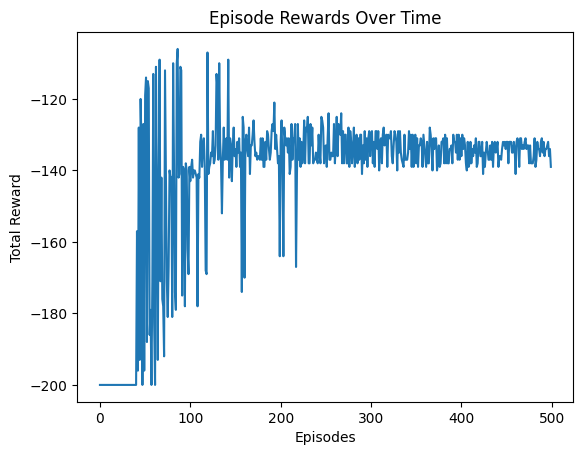

: 

In [ ]:
if __name__ == "__main__":
    # Initialize environment
    env = gym.make('MountainCar-v0')
    
    # Set hyperparameters for SARSA(λ)
    state_space = env.observation_space
    action_space = env.action_space
    alpha = 0.001  # Learning rate
    lamb = 0.9  # λ value for eligibility traces
    gamma = 0.99  # Discount factor
    epsilon = 0.3  # Exploration probability
    fourier_order = 2  # Fourier order
    max_non_zero_fourier = 2  # Max non-zero Fourier coefficients

    
    
    # Initialize SARSA(λ) agent
    agent = SarsaLambda(
        state_space=state_space,
        action_space=action_space,
        alpha=alpha,
        lamb=lamb,
        gamma=gamma,
        epsilon=epsilon,
        fourier_order=fourier_order,
        max_non_zero_fourier=max_non_zero_fourier
    )
    
    # Initialize trainer
    trainer = Trainer(
        environment=env,
        agent=agent,
        epsilon=epsilon,
        number_episodes=500,  # Number of episodes to train
        episode_reward_trigger=-150,  # Reward threshold for early stopping
        early_stopping=True  # Enable early stopping
    )
    
    # Train the agent
    print("Starting training...")
    trainer.train()
    print("Training completed!")
    trainer.test(N=50, verbose=True)
    print("Testing completed!")
    
    # Plot training results
    plt.plot(trainer.episode_reward_list)
    plt.title("Episode Rewards Over Time")
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.show()


    env.close()